In [ ]:
# Устанавливаем необходимые библиотеки
!pip install tensorflow numpy pandas

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
import zipfile
import os

# Загружаем ZIP-файл вручную
uploaded = files.upload()

# Разархивируем датасет
zip_path = "tph.zip"  # Имя загруженного файла
extract_path = "tph_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Проверяем файлы
os.listdir(extract_path)


Saving tph.zip to tph.zip


['val.txt', 'train.txt', 'test.txt']

In [ ]:
# Функция для загрузки данных
def load_dataset(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        lines = file.readlines()

    # Разделяем текст и метку (формат "текст;класс")
    data = [line.strip().split(";") for line in lines if ";" in line]

    df = pd.DataFrame(data, columns=["text", "label"])
    return df

# Загружаем файлы
train_df = load_dataset(os.path.join(extract_path, "train.txt"))
val_df = load_dataset(os.path.join(extract_path, "val.txt"))
test_df = load_dataset(os.path.join(extract_path, "test.txt"))

# Выводим размер датасетов
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

# Просмотр распределения классов
print(train_df["label"].value_counts())



Train size: 26406, Validation size: 2000, Test size: 2000
label
surprise    7278
anger       5859
joy         5362
sadness     4666
fear        1937
love        1304
Name: count, dtype: int64


In [ ]:
# Настройки токенизации
VOCAB_SIZE = 20000  # Максимальное количество уникальных слов
MAX_LEN = 25        # Ограничиваем длину предложений
EMBEDDING_DIM = 100 # Размерность эмбеддингов

# Создаем токенизатор
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"])

# Преобразуем текст в последовательности чисел
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df["text"]), maxlen=MAX_LEN, padding="post")
X_val = pad_sequences(tokenizer.texts_to_sequences(val_df["text"]), maxlen=MAX_LEN, padding="post")
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df["text"]), maxlen=MAX_LEN, padding="post")

# Кодируем метки классов
label_map = {label: idx for idx, label in enumerate(train_df["label"].unique())}
y_train = to_categorical(train_df["label"].map(label_map), num_classes=len(label_map))
y_val = to_categorical(val_df["label"].map(label_map), num_classes=len(label_map))
y_test = to_categorical(test_df["label"].map(label_map), num_classes=len(label_map))

# Проверяем форму данных
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (26406, 25), y_train shape: (26406, 6)
X_val shape: (2000, 25), y_val shape: (2000, 6)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

VOCAB_SIZE = 20000  # Размер словаря
MAX_LEN = 25        # Максимальная длина предложения
EMBEDDING_DIM = 200  # Увеличили размерность эмбеддингов
DROPOUT_RATE = 0.6  # Dropout для борьбы с переобучением
L2_REG = 0.01       # L2-регуляризация

model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),

    Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(L2_REG))),
    Dropout(DROPOUT_RATE),

    GRU(64, kernel_regularizer=l2(L2_REG)),
    Dropout(DROPOUT_RATE),

    Dense(32, activation="relu", kernel_regularizer=l2(L2_REG)),
    BatchNormalization(),  # Нормализация для устойчивости
    Dropout(DROPOUT_RATE),

    Dense(len(label_map), activation="softmax")  # Выходной слой
])

# Компиляция с уменьшенным learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Выводим архитектуру модели
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Количество эпох
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
826/826 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.2069 - loss: 7.7070 - val_accuracy: 0.1430 - val_loss: 4.2779 - learning_rate: 1.0000e-04
Epoch 2/20
826/826 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.3197 - loss: 3.8348 - val_accuracy: 0.2010 - val_loss: 3.2047 - learning_rate: 1.0000e-04
Epoch 3/20
826/826 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.4837 - loss: 2.6703 - val_accuracy: 0.4740 - val_loss: 2.3344 - learning_rate: 1.0000e-04
Epoch 4/20
826/826 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6788 - loss: 1.7609 - val_accuracy: 0.6110 - val_loss: 1.7991 - learning_rate: 1.0000e-04
Epoch 5/20
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7593 - loss: 1.2801 - val_accuracy: 0.6665 - val_loss: 1.3596 - learning_rate: 1.0000e-04
Epoch 6/20
826/826 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7981 - loss: 0.9850 - val_accuracy: 0.6700 - val_loss: 1.1813 - learning_rate: 1.0000e-04
Epoch 7/20
826/826 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/ste

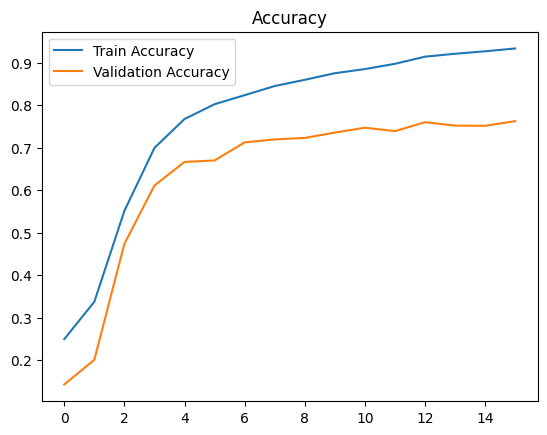

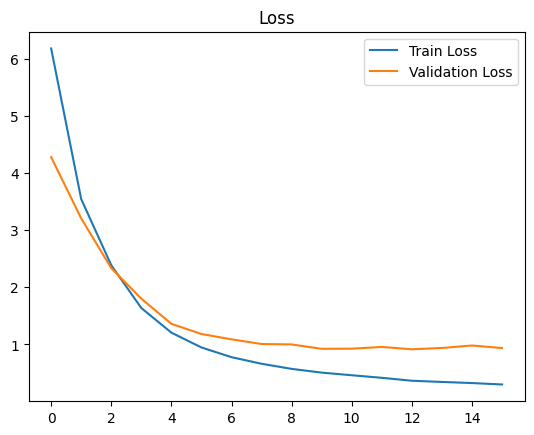

In [ ]:
# График точности
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

# График ошибки (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
# Оценка на тестовых данных
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7359 - loss: 0.9634
Test Accuracy: 0.7430


In [ ]:
# Сохранение модели
model.save("sentiment_model.h5")
print("Модель сохранена!")


Модель сохранена!
